In [1]:
import numpy as np
import numba
import quantecon as qe
import matplotlib.pyplot as plt
import datetime

In [2]:
beta=0.96
alpha=0.36
delta=0.08
a_max = 40.
b=3.

In [3]:
#rho=0.2
rho=0.4

#mu=0
mu=3
#mu=5

#sigma=0
sigma=0.4
#sigma=0.6
#sigma=0.9

In [4]:
x = qe.markov.approximation.tauchen(rho,sigma*(1-rho**2)**0.5, m = 3,n = 7)
l_grid = np.exp(x.state_values)
l_dis = x.stationary_distributions
L = np.sum(l_grid * l_dis)
l_min=l_grid[0]
piel = x.P

In [5]:
@numba.njit
def value_iter(v, c, beta, mu, piel):
    n=0
    err=1.
    
    while err > 1e-8 and n <= 1000:
        
        vn = v.copy()
        expc = piel @ np.transpose(v)
        
        if mu == 0:
            u = np.log(c)
        else:
            u = c ** (1 - mu) / (1 - mu)
        
        temp = u + beta * expc.reshape(1, 7, 601)
        for i in range(601):
            for j in range(7):
                v[i,j] =  np.max(temp[i,j,:])

        if n % 20 == 0:        
            err = np.max(np.abs(v - vn))
            
        n += 1
    return vn, temp

In [6]:
@numba.njit
def demo_iter(demo, plc, pie):
    err = 1.
    n = 0
    dims = pie.shape[1]
    while err > 1e-10 and n <= 1000:
        demon = np.zeros((601,dims), dtype=np.float64)
        for i in range(601):
            for j in range(dims):
                aprime = plc[i,j]
                demon[aprime,:]=demo[i,j]*pie[j,:] + demon[aprime,:]
        
        if n % 10 == 0:        
            err = np.max(np.abs(demon - demo))
            
        demo = demon.copy()
        n += 1
    return demon

In [7]:
v = np.ones((601,7),dtype=np.float64)
demo = np.ones((601,7), dtype=np.float64) / (601*7)

In [9]:
fig=np.empty((20,3), dtype=np.float64)

fig[:,0]=np.linspace(-0.04, (1-beta)/beta, 20)

for i in range(20):
    r=fig[i,0]
    k = (((r+delta)/(alpha * L**(1-alpha)))) ** (1/(alpha-1))
    fig[i,1]=k
    w = (1-alpha) * (k**alpha) * (L**(-alpha))
    
    if r > 0:
        phi = min(b, w*l_min/r)
    else:
        phi = b
    
    a_grid = (np.linspace(0, 1, 601, dtype=np.float64)**2)*(phi+a_max)-phi
    a_base = a_grid.reshape(601,1).repeat(7, axis=1)
    
    c = (1+r)*a_base + w*l_grid
    c = c.repeat(601, axis=1).reshape(601,7,601) - a_grid.reshape(1,601).repeat(7, axis = 0).reshape(1,7,601)
    c = np.clip(c, a_min=1e-10, a_max=50)
    
    v, temp = value_iter(v, c, beta, mu, piel)
    plc = np.argmax(temp, axis=2)
    demo = demo_iter(demo, plc, piel)
    fig[i,2] = np.sum(demo*a_grid.reshape(-1,1))

In [10]:
pr3=fig

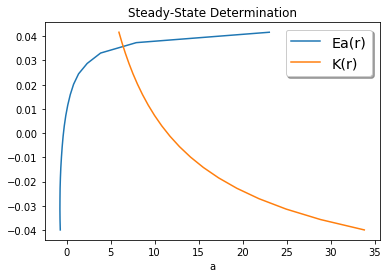

In [11]:
fig, ax = plt.subplots()
ax.plot(pr3[:,2], pr3[:,0], label='Ea(r)')
ax.plot(pr3[:,1], pr3[:,0], label='K(r)')
ax.set_title("Steady-State Determination")
ax.set_xlabel('a')

legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')

legend.get_frame()
#fig.savefig('A2_graphs/ss_dtm.png', dpi=500)

In [8]:
err = 1.
count = 0
r = 0.01

#momentum = 0.15
#lr = 0.001
#decay = 0.98
r_low=-0.04
r_up=(1-beta)/beta
start = datetime.datetime.now()

while err >= 15e-4 and count <= 1000:
    k = (((r+delta)/(alpha * L**(1-alpha)))) ** (1/(alpha-1))
    w = (1-alpha) * (k**alpha) * (L**(-alpha))
    
    if r > 0:
        phi = min(b, w*l_min/r)
    else:
        phi = b
    
    a_grid = (np.linspace(0, 1, 601, dtype=np.float64)**2)*(phi+a_max)-phi
    a_base = a_grid.reshape(601,1).repeat(7, axis=1)
    
    c = (1+r)*a_base + w*l_grid
    c = c.repeat(601, axis=1).reshape(601,7,601) - a_grid.reshape(1,601).repeat(7, axis = 0).reshape(1,7,601)
    c = np.clip(c, a_min=1e-10, a_max=50)
    
    v, temp = value_iter(v, c, beta, mu, piel)
    plc = np.argmax(temp, axis=2)
    demo = demo_iter(demo, plc, piel)
    kprime = np.sum(demo*a_grid.reshape(-1,1))
    
    err = np.abs(k - kprime)
    if kprime < k:
        r_low = r
    else:
        r_up = r
    r = 0.5*(r_up+r_low)
    
    if count % 10 ==0:
        print(count)
    
    count += 1

end = datetime.datetime.now()
print(end-start)

0
10
0:02:20.071730


In [16]:
k, kprime, r, w

(6.390075882618307, 6.388724934722765, 0.03617273966471357, 1.2091523735138896)

In [9]:
k, kprime, r, w

(6.3706888337831336,
 6.370343005078033,
 0.03639984130859379,
 1.2078304346946371)

In [18]:
r

0.06263229729956943

In [13]:
w

1.0773325810396563

In [9]:
@numba.guvectorize(['f8[:], f8, f8, f8[:,:], f8[:,:], f8[:,:]'],
                  '(a),(),(),(b,c),(d,d)->(b,c)', nopython=True)
def demo_iter_re(a_grid, phi, a_max, plc, pie, demon):
    err = 1.
    n = 0
    
    itv = a_grid[1:601]-a_grid[0:600]
    
    while err > 1e-6 and n <= 1000:
        demo = demon.copy()
        temp = np.zeros((601*7,8), dtype=np.float64)
        demon = np.zeros((601,7), dtype=np.float64)
        for i in range(601):
            for j in range(7):
                temp[i*7+j,0]=plc[i,j]
                temp[i*7+j,1:8]=demo[i,j] * pie[j,:]
        
        for k in range(600):
            location = np.where(np.logical_and(np.greater_equal(temp[:,0],a_grid[k]), np.less_equal(temp[:,0],a_grid[k+1])))
            for l in location:
                demon[k,:] = np.sum(temp[l,1:8]*((temp[l,0]-a_grid[k])/itv[k]), axis=0) + demon[k,:]
                demon[k+1,:] = np.sum(temp[l,1:8]*((a_grid[k+1]-temp[l,0])/itv[k]), axis=0) + demon[k+1,:]
        
        if n % 10 == 0:        
            err = np.max(np.abs(demon - demo))
            
        n += 1

In [46]:
demon = np.ones((601,7), dtype=np.float64) / (601*7)
    
itv = (a_max+phi)/1200
a_itv = np.empty((601,2), dtype=np.float64)
a_itv[:,0] = a_grid - itv
a_itv[:,1] = a_grid + itv

In [47]:
demon = np.ones((601,7), dtype=np.float64) / (601*7)
demo = demon.copy()
temp = np.zeros((601*7,8), dtype=np.float64)
demon = np.zeros((601,7), dtype=np.float64)
for i in range(601):
    for j in range(7):
        temp[i*7+j,0]=plc_re[i,j]
        temp[i*7+j,1:8]=demo[i,j] * piel[j,:]
        
for k in range(601):
    location = np.where(np.logical_and(np.greater_equal(temp[:,0],a_itv[k,0]), np.less(temp[:,0],a_itv[k,1])))
    demon[k,:] = np.sum(temp[location,1:8], axis=1)

In [49]:
demon.sum()

1.0

In [15]:
demo.sum()

1.0000000000007043

In [14]:
demon = np.ones((601,7), dtype=np.float64) / (601*7)

In [15]:
tester = demo_iter_re(a_grid, phi, a_max, plc, pie, demon)

array([[-3.        , -3.        , -2.95333333, ..., -2.34666667,
        -1.6       , -0.38666667],
       [-3.        , -3.        , -2.95333333, ..., -2.3       ,
        -1.55333333, -0.34      ],
       [-3.        , -3.        , -2.90666667, ..., -2.25333333,
        -1.50666667, -0.29333333],
       ...,
       [23.88      , 24.02      , 24.25333333, ..., 25.        ,
        25.        , 25.        ],
       [23.92666667, 24.06666667, 24.3       , ..., 25.        ,
        25.        , 25.        ],
       [23.97333333, 24.11333333, 24.34666667, ..., 25.        ,
        25.        , 25.        ]])